In [105]:
import requests
import re
from datetime import datetime, timedelta
import os
import pandas as pd
import xml.etree.ElementTree as et
from shapely.geometry import Point, Polygon

In [106]:
# Base URL for CAP files
base_url = "https://dd.weather.gc.ca/alerts/cap/"

# Get the current date
current_date = datetime.now().strftime('%Y%m%d')

# Create a list of two-digit hour strings for the past 3 hours
now = datetime.now()
hours = [(now - timedelta(hours=i)).strftime('%H') for i in range(4)]

In [107]:
# List of responsible office codes
responsible_offices = ['CWUL', 'CWEG', 'CWNT', 'CWWG', 'CWVR', 'CWTO', 'CYQX', 'CWAO', 'CWIS', 'CWHX', 'LAND']


In [108]:
# Create a list to store URLs ending with .cap
urls_cap = []

# Create URLs for each responsible office, hour, and code
for office in responsible_offices:
    for hour in hours:
        url = f"{base_url}{current_date}/{office}/{hour}/"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                # Extract filenames from the response using regular expressions
                filenames = re.findall(r'href="(.*\.cap)"', response.text)
                # Create complete URLs for .cap files and add them to the list
                for filename in filenames:
                    cap_url = url + filename
                    urls_cap.append(cap_url)
                    print(f"Added {cap_url} to the list.")
        except requests.Timeout:
            print(f"Request to {url} timed out.")
        except requests.RequestException as e:
            print(f"Request to {url} failed: {e}")


Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/00/T_WWCN13_C_CWVR_202308130040_2292154699.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWTO/00/T_WHCN13_C_CWTO_202308130014_0261392502.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWTO/00/T_WHCN13_C_CWTO_202308130014_1700823332.cap to the list.


In [109]:
import pandas as pd
import xml.etree.ElementTree as et
from shapely.geometry import Point, Polygon
import requests

# Define namespaces for CAP elements
namespaces = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}
df = []

# Iterate over each file
for url in urls_cap:
    # Fetch the XML content from the URL
    response = requests.get(url)
    if response.status_code == 200:
        xml_content = response.content
        root = et.fromstring(xml_content)  # Parse the XML content
        
        # Extract event data
        event = root.find('.//cap:event', namespaces).text

        # Extract polygon data into a list of dictionaries
        data = []
        for area in root.findall('.//cap:area', namespaces):
            area_desc = area.find('.//cap:areaDesc', namespaces).text
            polygon_coords = area.find('.//cap:polygon', namespaces).text
            coords = polygon_coords.split()  # Split coordinates into individual pairs

            # Create a dictionary for each set of coordinates
            for coord_pair in coords:
                lat, lon = map(float, coord_pair.split(','))
                data.append({'event': event, 'areaDesc': area_desc, 'latitude': lat, 'longitude': lon})

        # Create a DataFrame from the extracted data
        polygon_df = pd.DataFrame(data)
        df.append(polygon_df)  # Append to the list of DataFrames

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(df, ignore_index=True)

# Display the first 6 rows of the concatenated DataFrame


In [110]:
final_df.head(30)

,event,areaDesc,latitude,longitude
0,heat,Fraser Canyon - south including Lytton,50.3431,-121.9660
1,heat,Fraser Canyon - south including Lytton,50.3298,-121.6568
2,heat,Fraser Canyon - south including Lytton,50.4410,-121.4319
3,heat,Fraser Canyon - south including Lytton,50.2225,-121.3396
4,heat,Fraser Canyon - south including Lytton,50.0000,-121.2600
5,heat,Fraser Canyon - south including Lytton,49.7449,-121.1514
6,heat,Fraser Canyon - south including Lytton,49.4682,-121.0637
7,heat,Fraser Canyon - south including Lytton,49.4676,-121.0408
8,heat,Fraser Canyon - south including Lytton,49.3534,-121.0576
9,heat,Fraser Canyon - south including Lytton,49.3456,-121.0435


<Axes: xlabel='latitude', ylabel='longitude'>

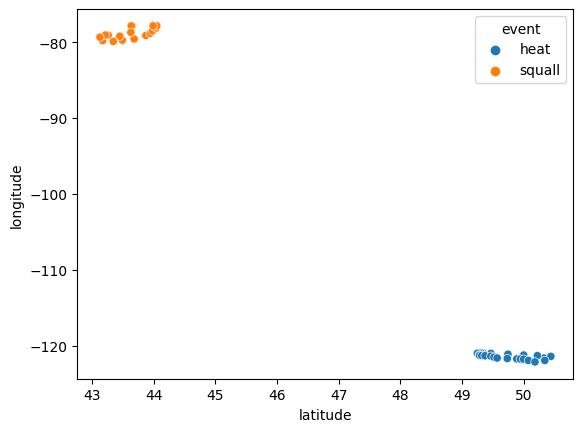

In [111]:
import seaborn as sns
sns.scatterplot(data=final_df,x='latitude',y='longitude',hue = 'event')

In [112]:
import pandas as pd
cities = pd.read_csv(r'C:\Users\srika\OneDrive\Documents\York\Sem-1 york\MMAI 5100 - database fundamentals\ca_geo_dimension.csv')
cities.sample(10)

,province,region,zipcode,latitude,longitude
561682,Ontario,Waterloo,N2V2M1,43.472768,-80.583240
137845,Quebec,Capitale-Nationale,G5A1E8,47.647377,-70.160290
468307,Ontario,Halton,L7N1M7,43.341197,-79.782452
2901,Newfoundland & Labrador,Conception Bay - St. Johns,A1C3G9,47.567472,-52.726710
435959,Ontario,Peel,L4Y2X4,43.614701,-79.611085
114454,Quebec,Capitale-Nationale,G1K2B2,46.809771,-71.231610
123287,Quebec,Capitale-Nationale,G2B1T9,46.844131,-71.356962
64556,New Brunswick,York,E3A4Y2,45.979363,-66.683385
127363,Quebec,Capitale-Nationale,G3A1J4,46.737727,-71.456884
37198,Nova Scotia,Kings,B4N3K2,45.071238,-64.419986


In [113]:
%%skip
from shapely.geometry import Point, Polygon
import pandas as pd

# Group the latitude and longitude points by 'areaDesc'
grouped = final_df.groupby('areaDesc').agg(list)

# Create a dictionary to store polygons for each area
area_polygons = {}

# Iterate over each group
for area_desc, row in grouped.iterrows():
    # Create a Shapely Polygon
    polygon_coords = [(lon, lat) for lat, lon in zip(row['latitude'], row['longitude'])]
    polygon = Polygon(polygon_coords)
    
    # Store the polygon in the dictionary
    area_polygons[area_desc] = polygon

# List to store filtered city data
filtered_cities = []

# Iterate through each city
for index, city in cities.iterrows():
    city_point = Point(city['longitude'], city['latitude'])
    
    # Check if the city is inside any of the polygons
    for area_desc, polygon in area_polygons.items():
        if city_point.within(polygon):
            filtered_cities.append({'province': city['province'], 'region': city['region'], 'areaDesc': area_desc})

# Create a DataFrame from the filtered cities
filtered_cities_df = pd.DataFrame(filtered_cities)

# Add 'event' column to the filtered cities DataFrame
event_name = "thunderstorm"  # Replace with the actual event name
filtered_cities_df['event'] = event_name


UsageError: Cell magic `%%skip` not found.


In [114]:
%%skip
polygon.head(4)

UsageError: Cell magic `%%skip` not found.


In [115]:
%%skip
filtered_cities_df

UsageError: Cell magic `%%skip` not found.


In [116]:
import pandas as pd
import xml.etree.ElementTree as et
import requests

# Define namespaces for CAP elements
namespaces = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}
df = []

# Iterate over each file
for url in urls_cap:
    # Fetch the XML content from the URL
    response = requests.get(url)
    if response.status_code == 200:
        xml_content = response.content
        root = et.fromstring(xml_content)  # Parse the XML content
        
        # Extract event data
        event = root.find('.//cap:event', namespaces).text

        # Extract polygon data into a list of dictionaries
        data = []
        for area in root.findall('.//cap:area', namespaces):
            area_desc = area.find('.//cap:areaDesc', namespaces).text
            polygon_coords = area.find('.//cap:polygon', namespaces).text
            coords = polygon_coords.split()  # Split coordinates into individual pairs

            # Create a polygon string
            polygon_str = ",".join(coords)

            data.append({'event': event, 'areaDesc': area_desc, 'polygon': polygon_str})

        # Append to the list of dictionaries
        df.append(data)

# Flatten the list of dictionaries and create a DataFrame
final_df = pd.DataFrame([item for sublist in df for item in sublist])

# Display the first 6 rows of the DataFrame
final_df.drop_duplicates()
final_df.head(5)

,event,areaDesc,polygon
0,heat,Fraser Canyon - south including Lytton,"50.3431,-121.966,50.3298,-121.6568,50.441,-121..."
1,heat,canyon du Fraser - sud incluant Lytton,"50.3431,-121.966,50.3298,-121.6568,50.441,-121..."
2,squall,Western Lake Ontario,"43.1293,-79.322,43.1723,-79.7776,43.3464,-79.8..."
3,squall,lac Ontario Ouest,"43.1293,-79.322,43.1723,-79.7776,43.3464,-79.8..."
4,squall,Western Lake Ontario,"43.1293,-79.322,43.1723,-79.7776,43.3464,-79.8..."


In [117]:
import pandas as pd

# Your existing code to create final_df
# ...

# Group final_df by 'event' and 'areaDesc'
grouped = final_df.groupby(['event', 'areaDesc'])['polygon'].first().reset_index()

# Merge grouped DataFrame with final_df based on 'event' and 'areaDesc' columns
final_df = final_df.merge(grouped, on=['event', 'areaDesc'], how='left')

# Drop the duplicated 'polygon_x' column and rename 'polygon_y' to 'polygon'
final_df.drop(columns=['polygon_x'], inplace=True)
final_df.rename(columns={'polygon_y': 'polygon'}, inplace=True)

# Drop duplicate rows based on 'event' and 'areaDesc' columns
final_df.drop_duplicates(subset=['event', 'areaDesc'], keep='first', inplace=True)

# Reset the DataFrame index
final_df.reset_index(drop=True, inplace=True)

final_df.head(5)


,event,areaDesc,polygon
0,heat,Fraser Canyon - south including Lytton,"50.3431,-121.966,50.3298,-121.6568,50.441,-121..."
1,heat,canyon du Fraser - sud incluant Lytton,"50.3431,-121.966,50.3298,-121.6568,50.441,-121..."
2,squall,Western Lake Ontario,"43.1293,-79.322,43.1723,-79.7776,43.3464,-79.8..."
3,squall,lac Ontario Ouest,"43.1293,-79.322,43.1723,-79.7776,43.3464,-79.8..."


In [118]:
final_df.shape

(4, 3)

In [119]:
# Create a list to store alert cities
alert_cities = []

# Iterate over each row in final_df
for _, row in final_df.iterrows():
    event = row['event']
    area_desc = row['areaDesc']
    polygon_coords = [(float(coord), float(lon_coord)) for coord, lon_coord in zip(row['polygon'].split(','), row['polygon'].split(',')[1::2])]
    
    # Create a Shapely Polygon
    polygon = Polygon(polygon_coords)
    
    # Iterate over each city
    for index, city in cities.iterrows():
        city_point = Point(city['longitude'], city['latitude'])
        
        # Check if the city is inside the polygon
        if city_point.within(polygon):
            alert_cities.append({
                'province': city['province'],
                'region': city['region'],
                'alert': event
            })


KeyboardInterrupt: 

In [ ]:
alert_cities.head(5)